<a href="https://colab.research.google.com/github/sraeisi/MachineLearning_Physics/blob/master/2/MLP_NN_ModelEvaluationa%26Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import style
plt.style.use('seaborn-talk')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras

import requests
import io

from matplotlib import rcParams
# rcParams['figure.figsize'] = 15,7
plt.rc('figure', figsize=(12,7) )         # Image size


<ipython-input-1-29e7909fb1f1>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')


## GPU

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
!nvidia-smi

Sun May 12 11:58:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8483666942937573027
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17999203856976591578
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

tf.config.experimental.set_memory_growth(gpus[0] , True)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data: Farsi Hand-written digits classification

In [6]:
url = 'https://raw.githubusercontent.com/sraeisi/MachineLearning_Physics/master/Data/Farsi_digits_X.npz'
s=requests.get(url, stream=True).content
X = np.load(io.BytesIO(s) )['arr_0']
url = 'https://raw.githubusercontent.com/sraeisi/MachineLearning_Physics/master/Data/Farsi_digits_Y.npz'
s=requests.get(url, stream=True).content
Y = np.load(io.BytesIO(s) )['arr_0']

# X = np.load('X.npz')['arr_0']
# Y = np.load('Y.npz')['arr_0']


from sklearn.utils import shuffle
X, Y = shuffle(X,Y, random_state = 0 )

In [7]:
print('Each image is of the form: {}'.format(X[0].shape ) )

Each image is of the form: (32, 32)


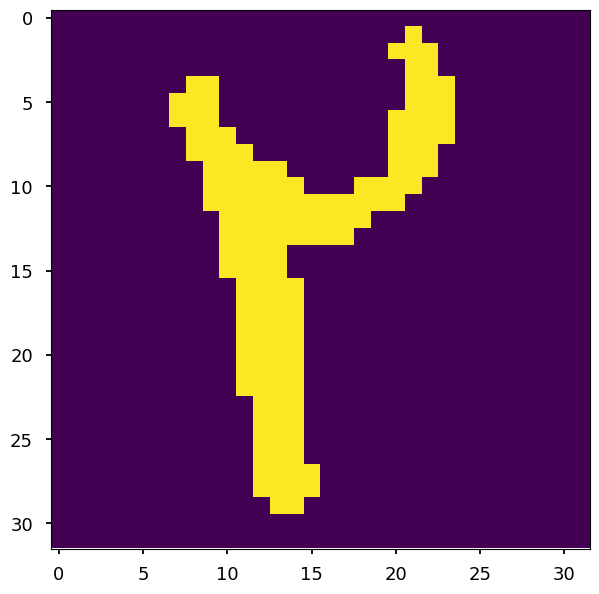

In [9]:
plt.imshow(X[20])

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

## Pytorch

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
x_tr = torch.from_numpy(X_train).float()
x_ts = torch.from_numpy(X_test).float()

y_tr = torch.from_numpy(Y_train)
y_ts = torch.from_numpy(Y_test)

n_w, n_h = x_tr[0].size()
n_out = 10

In [14]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        output = F.softmax(x, dim=1)

        return output

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


## Simple Training

In [15]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[0.0960, 0.1098, 0.1079, 0.0901, 0.1141, 0.1266, 0.1006, 0.0831, 0.0869,
         0.0848]], grad_fn=<SoftmaxBackward0>)


In [20]:
net = Net()

optimizer = optim.Adam(net.parameters(), lr=.05, betas=(0.9, 0.999))

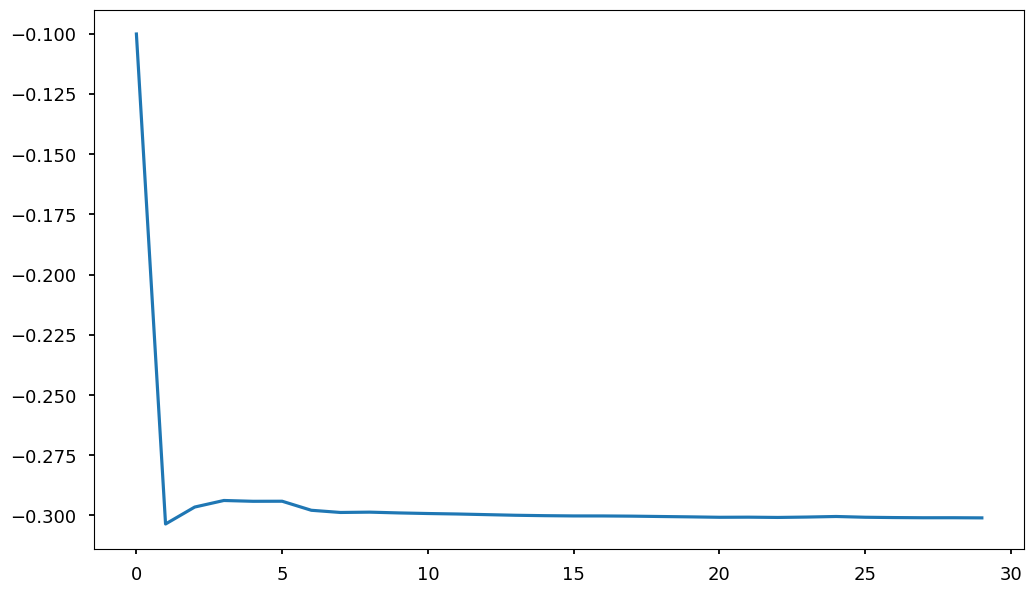

CPU times: user 32.1 s, sys: 1.76 s, total: 33.8 s
Wall time: 34.7 s


In [21]:
%%time
epochs = 30

#We also need to keep track of the loss.
losses = []

for i in range(epochs):
    #Clear the previous gradients
    optimizer.zero_grad()

    #Precit the output for Given input
    y_pred = net.forward(x_tr)

    loss = F.nll_loss(y_pred, y_tr)
    losses += [loss.detach().numpy().copy()]


    loss.backward()
    optimizer.step()


plt.plot(losses)
plt.show()

7358
This sample is a 3.



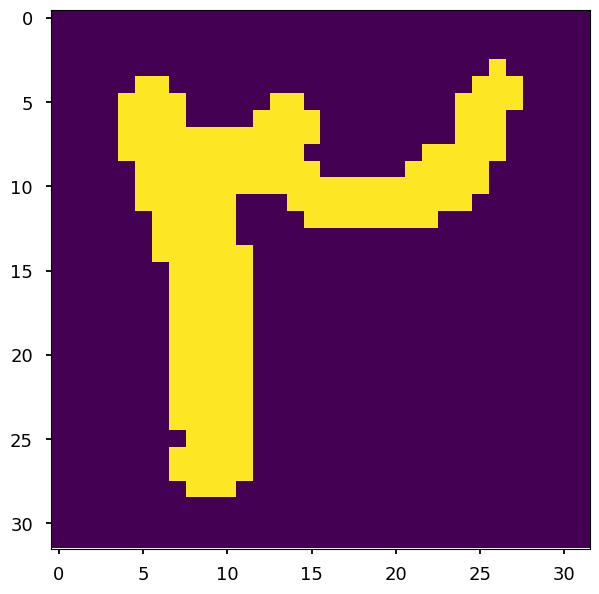

In [29]:
ind = np.random.randint(0, len(x_ts))
print(ind)
plt.imshow(x_ts[ind] )
pred = net.forward(x_ts[ind].view(-1,32,32)).argmax()
print(f'This sample is a {pred}.\n')

In [ ]:
### Measure the accuracy of the model,
### Is it acceptable?

## Minibatch

Let's add mini-batch optimization and keep track of the accuracy.

In [ ]:
# del net
net = Net()
optimizer = optim.Adam(net.parameters(), lr=.01)
criterion = nn.NLLLoss()

In [ ]:
x_tr = torch.from_numpy(X_train).float()
x_ts = torch.from_numpy(X_test).float()

y_tr = torch.from_numpy(Y_train)
y_ts = torch.from_numpy(Y_test)

In [ ]:
(net.forward(x_ts).argmax(axis=1)==y_ts).sum()/len(y_ts)
# net.forward(x_ts).argmax(axis=1)

tensor(0.1248)

In [ ]:
n_epoch=3
btch_size = 1000

### Data Loaders

In [ ]:
## Training data
training_dataset = torch.utils.data.TensorDataset(x_tr, y_tr)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=btch_size, shuffle=True)

## Test data
test_dataset = torch.utils.data.TensorDataset(x_ts, y_ts)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=btch_size, shuffle=True)

In [ ]:
training_dataset[0]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor(8))

torch.Size([1000, 32, 32])
tensor(0)


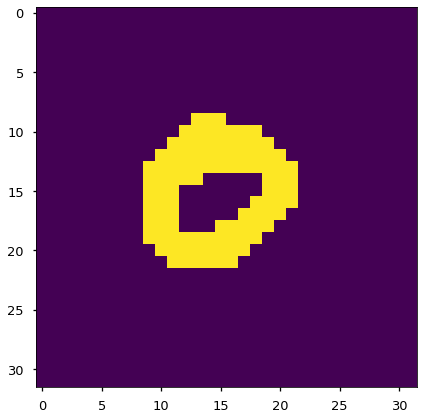

In [ ]:
for x, y in train_loader:
  print(x.size() )
  plt.imshow(x[0].numpy())
  print(y[0])
  break

### Training

In [ ]:
%%time
# epochs = 3
# batch_size = 500
n_s = len(x_tr)
n_ts = len(x_ts)


#We also need to keep track of the loss.
sample_rate = 10
training_losses = []
test_losses = []

training_accuracy = []
test_accuracy = []
for i in range(n_epoch):
  print(f'Starting {i} epoch.')
  # print(len(training_losses))
  ind = 0

  for i, (X_batch, Y_batch) in enumerate(train_loader):
    X_batch = X_batch.reshape(-1, n_w*n_h)#.to(device)
    Y_batch = Y_batch#.to(device)
    ind += 1

    # Forward pass
    # #Precit the output for Given input
    outputs = net(X_batch)
    loss = criterion(outputs, Y_batch)

    # Backward and optimize
    #Clear the previous gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ## Every sample_rate, we record the loss and accuracy.
    if ind%(int(n_s/btch_size/sample_rate))==0:
      y_tr_pred = net.forward(x_tr)
      training_losses += [F.nll_loss( y_tr_pred, y_tr).item() ]
      training_accuracy += [torch.sum( y_tr ==
                                      torch.argmax( y_tr_pred, axis=1 ) ).item()/n_s ]

      # print(F.nll_loss( net.forward(x_ts) , y_ts) )
      y_ts_pred = net.forward(x_ts)
      test_losses += [F.nll_loss( y_ts_pred, y_ts).item() ]
      test_accuracy += [torch.sum( y_ts ==
                                      torch.argmax( y_ts_pred, axis=1 )).item()/n_ts ]





Starting 0 epoch.
Starting 1 epoch.
Starting 2 epoch.
CPU times: user 23.9 s, sys: 135 ms, total: 24.1 s
Wall time: 23.9 s


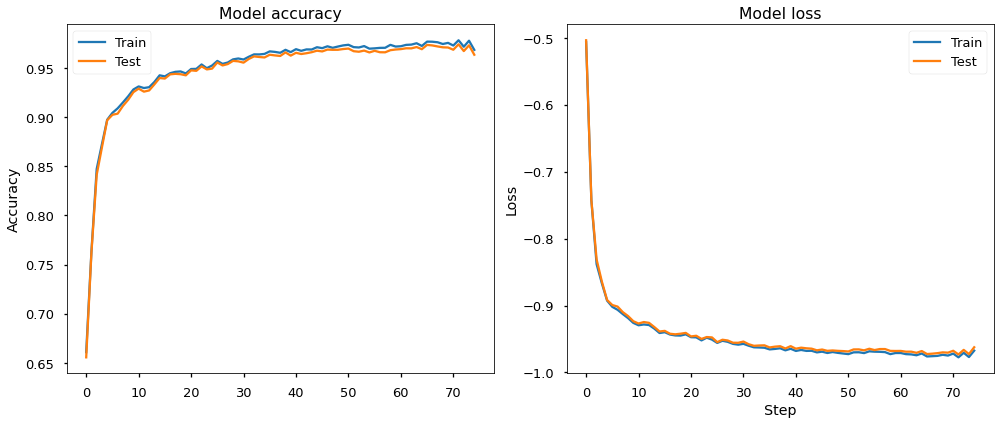

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(training_accuracy)
plt.plot(test_accuracy)
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss', xlabel = 'Step')
plt.plot(training_losses)
plt.plot(test_losses )
plt.legend(['Train', 'Test'], loc=0)

plt.tight_layout()
plt.show()

## GPU

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

n_epoch=3
btch_size = 1000

x_tr = torch.from_numpy(X_train).float()
x_ts = torch.from_numpy(X_test).float()

y_tr = torch.from_numpy(Y_train)
y_ts = torch.from_numpy(Y_test)

## Training data
training_dataset = torch.utils.data.TensorDataset(x_tr, y_tr)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=btch_size, shuffle=True)

## Test data
test_dataset = torch.utils.data.TensorDataset(x_ts, y_ts)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=btch_size, shuffle=True)




In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
%%time
n_w, n_h = x_tr[0].size()
n_s = len(x_tr)
n_ts = len(x_ts)


#We also need to keep track of the loss.
sample_rate = 20
training_losses = []
test_losses = []

training_accuracy = []
test_accuracy = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model = NeuralNet(n_w * n_h, [100,80], 10).to(device)
model = Net().to(device)

# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=.01)

# Train the model
total_step = len(train_loader)
for epoch in range(n_epoch):
    print(f'Starting {epoch} epoch.')

    for i, (X_batch, Y_batch) in enumerate(train_loader):
        # Move tensors to the configured device
        X_batch = X_batch.reshape(-1, n_w*n_h).to(device)
        Y_batch = Y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


        ## Every sample_rate, we record the loss and accuracy.
        if i%(int(n_s/btch_size/sample_rate))==0:
          y_tr_pred = model.forward(x_tr.to(device)).cpu()
          training_losses += [F.nll_loss( y_tr_pred, y_tr).item() ]
          training_accuracy += [torch.sum( y_tr ==
                                          torch.argmax( y_tr_pred, axis=1 ) ).item()/n_s ]

          # print(F.nll_loss( net.forward(x_ts) , y_ts) )
          y_ts_pred = model.forward(x_ts.to(device)).cpu()
          test_losses += [F.nll_loss( y_ts_pred, y_ts).item() ]
          test_accuracy += [torch.sum( y_ts ==
                                          torch.argmax( y_ts_pred, axis=1 )).item()/n_ts ]


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.reshape(-1, n_w*n_h).to(device)
        Y_batch = Y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += Y_batch.size(0)
        correct += (predicted == Y_batch).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))


Starting 0 epoch.
Starting 1 epoch.
Starting 2 epoch.
Accuracy of the network on the 10000 test images: 96.90870720650305 %
CPU times: user 11 s, sys: 74.7 ms, total: 11 s
Wall time: 11.1 s


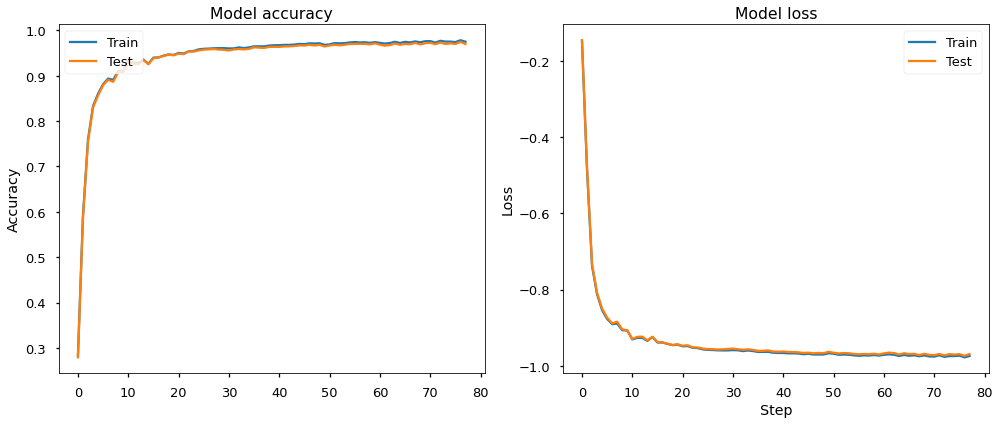

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(training_accuracy)
plt.plot(test_accuracy)
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss', xlabel = 'Step')
plt.plot(training_losses)
plt.plot(test_losses )
plt.legend(['Train', 'Test'], loc=0)

plt.tight_layout()
plt.show()

## Keras

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
set(Y_test)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
X_train.shape

(76764, 32, 32)

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),
    keras.layers.Dense(128, activation= 'relu' ),
    keras.layers.Dense(10, activation='softmax'  )
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 132,490
Trainable params: 132,490
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,Y_train, validation_split=0.25, epochs=5, batch_size=1000)

Epoch 1/5
116/116 [==============================] - 3s 8ms/step - loss: 0.3512 - accuracy: 0.9032 - val_loss: 0.1698 - val_accuracy: 0.9514
Epoch 2/5
116/116 [==============================] - 1s 6ms/step - loss: 0.1388 - accuracy: 0.9616 - val_loss: 0.1258 - val_accuracy: 0.9654
Epoch 3/5
116/116 [==============================] - 1s 6ms/step - loss: 0.1014 - accuracy: 0.9720 - val_loss: 0.1034 - val_accuracy: 0.9722
Epoch 4/5
116/116 [==============================] - 1s 6ms/step - loss: 0.0789 - accuracy: 0.9786 - val_loss: 0.0920 - val_accuracy: 0.9744
Epoch 5/5
116/116 [==============================] - 1s 6ms/step - loss: 0.0632 - accuracy: 0.9834 - val_loss: 0.0821 - val_accuracy: 0.9770


In [ ]:
Y_predicted = np.argmax( model.predict(X_test) , axis=1 )
cm = confusion_matrix(Y_test, Y_predicted)
print(cm)

[[2521    0    0    0    0   11    1    3    0    0]
 [   1 2497    2    0    1    0    5    2    0    3]
 [   3   19 2384   53   11    0   16    7    0    7]
 [   1    0   56 2446   38    2    1    0    0    0]
 [   4    9   20   60 2546   20   11    6    2   14]
 [  18    3    1    3    3 2456    4    0    8    1]
 [   4    5   12    0    5    1 2548   10    2   21]
 [   7    4    5    2    4    5    3 2578    0    0]
 [   4    5    0    4    2    3    6    0 2509   15]
 [   0   17    3    0    1    0   22    0    8 2493]]


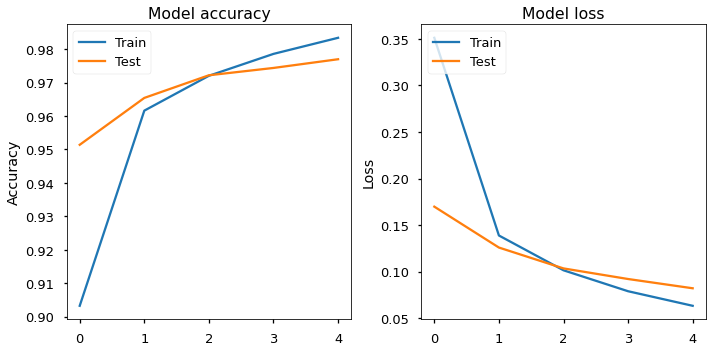

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
Y_oh = keras.utils.to_categorical(Y, num_classes=10, dtype=int)
print(Y[4])
Y_oh[4]

3


array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
Y_oh = keras.utils.to_categorical(Y, num_classes=10, dtype=int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_oh, random_state=0)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),
    keras.layers.Dense(128, activation= 'relu' ),
    keras.layers.Dense(10, activation='softmax'  )
])

## We need to change the loss function for the one-hot encoding
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,Y_train,
                    validation_split=0.25,
                    epochs=50,
                    batch_size=500,
                    verbose=0)

In [ ]:
print(Y_test[:3])
model.predict(X_test[:3]).argmax(axis=1)

[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]]


array([1, 8, 6])

In [ ]:
Y_predicted = np.argmax( model.predict(X_test) , axis=1 )
cm = confusion_matrix(np.argmax( Y_test , axis=1 ), Y_predicted)
print(cm)


[[2519    0    0    0    2   14    0    0    1    0]
 [   2 2500    3    0    1    0    2    0    0    3]
 [   2    9 2449   18   11    0    5    4    0    2]
 [   0    0   49 2466   25    2    2    0    0    0]
 [   3    4   13   35 2612   11    7    4    1    2]
 [   6    1    1    4    2 2473    5    0    4    1]
 [   1    6    8    2    3    2 2564    4    1   17]
 [   2    3    4    0    3    3    4 2589    0    0]
 [   2    4    0    1    1    4    2    1 2521   12]
 [   0   13    0    0    1    0   18    0    6 2506]]


In [ ]:
model.predict(X_test[:1]).argmax(axis=1)

array([1])

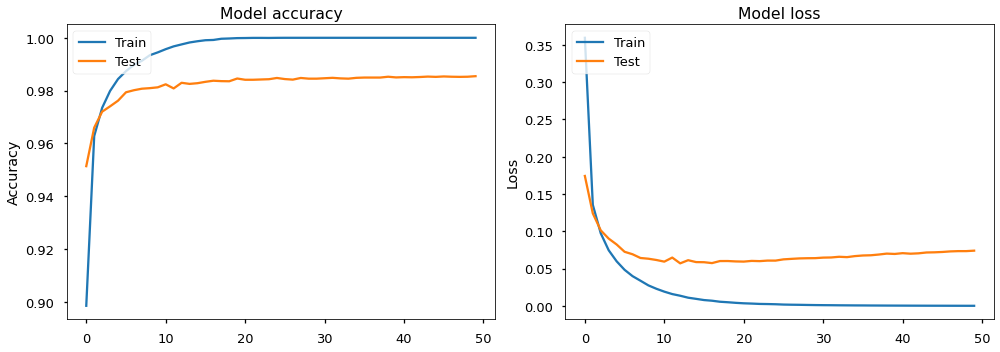

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

## Handling Overfitting


In [ ]:
Y_oh = keras.utils.to_categorical(Y, num_classes=10, dtype=int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_oh, random_state=0)

In [ ]:
model_ovfit1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),
    keras.layers.Dense(128,activation=tf.nn.relu,
                       kernel_regularizer=keras.regularizers.l2(.1)
    ),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(.1)),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(.1)),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model_ovfit1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_ovfit1.build([None, 2])
model_ovfit1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               131200    
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 10)                1290      
                                                                 
Total params: 165,514
Trainable params: 165,514
Non-trainable params: 0
_________________________________________________________________


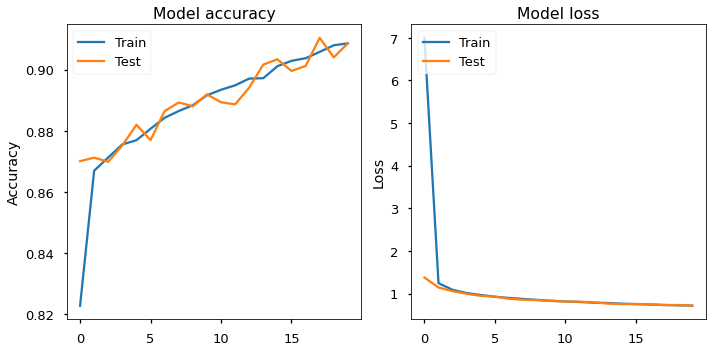

In [ ]:
n_s = 1000000
history_ovfit1 =  model_ovfit1.fit(X_train[:n_s],Y_train[:n_s],
#                           validation_split=0.05,
                          validation_data = (X_test, Y_test),
                          epochs=20 ,
                          batch_size=256,
                          verbose=0)

# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history_ovfit1.history['accuracy'])
plt.plot(history_ovfit1.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history_ovfit1.history['loss'])
plt.plot(history_ovfit1.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
print(np.argmax(Y_test[:3],axis=1))
model_ovfit1.predict(X_test[:3]).argmax(axis=1)
set(model_ovfit1.predict(X_test).argmax(axis=1))

[1 8 6]


{9}

Epoch 1/20
300/300 [==============================] - 3s 8ms/step - loss: 0.6469 - accuracy: 0.7931 - val_loss: 0.1581 - val_accuracy: 0.9545
Epoch 2/20
300/300 [==============================] - 2s 7ms/step - loss: 0.2385 - accuracy: 0.9333 - val_loss: 0.1161 - val_accuracy: 0.9681
Epoch 3/20
300/300 [==============================] - 2s 6ms/step - loss: 0.1898 - accuracy: 0.9476 - val_loss: 0.1041 - val_accuracy: 0.9714
Epoch 4/20
300/300 [==============================] - 2s 6ms/step - loss: 0.1610 - accuracy: 0.9553 - val_loss: 0.0914 - val_accuracy: 0.9751
Epoch 5/20
300/300 [==============================] - 2s 7ms/step - loss: 0.1408 - accuracy: 0.9614 - val_loss: 0.0847 - val_accuracy: 0.9766
Epoch 6/20
300/300 [==============================] - 2s 8ms/step - loss: 0.1292 - accuracy: 0.9639 - val_loss: 0.0859 - val_accuracy: 0.9771
Epoch 7/20
300/300 [==============================] - 2s 7ms/step - loss: 0.1223 - accuracy: 0.9655 - val_loss: 0.0750 - val_accuracy: 0.9794
Epoch 

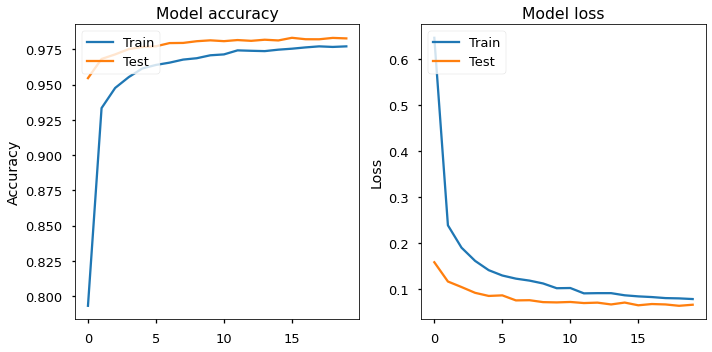

In [ ]:
model_ovfit2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),
    keras.layers.Dense(128,activation=tf.nn.relu ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation=tf.nn.relu ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation=tf.nn.relu ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])


model_ovfit2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_ovfit2 = model_ovfit2.fit(X_train[:n_s],Y_train[:n_s],
                                  validation_data = (X_test, Y_test),
#                                   validation_split=0.05,
                                  epochs=20 ,
                                  batch_size=256, verbose=1)

# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history_ovfit2.history['accuracy'])
plt.plot(history_ovfit2.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history_ovfit2.history['loss'])
plt.plot(history_ovfit2.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

***Assignment*** Play with these models and their hyperparameters to get a sense of how they affect the NN.

## Full Pipeline

### Cross-Validation

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [ ]:
def model_fn():
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.1) ),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dense(10, activation=tf.nn.softmax)
        ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
epch = 10
batch_sz = 500

from sklearn.model_selection import KFold
n_folds = 3
kf = KFold(n_splits=n_folds, shuffle=True)


loss = []
acc = []
val_loss = []
val_acc = []

# cross validate:
for train_index, val_index in kf.split(X):
    model = model_fn()
    hist = model.fit(X[train_index], Y[train_index],
                     epochs=epch,
                     batch_size=500,
                     validation_data = (X[val_index], Y[val_index]),
                     verbose=0)
    loss.append(hist.history['loss'])
    acc.append(hist.history['accuracy'])
    val_loss.append([hist.history['val_loss']])
    val_acc.append(hist.history['val_accuracy'])

loss = np.array(loss).reshape(n_folds, epch )
acc = np.array(acc).reshape(n_folds, epch )
val_loss = np.array(val_loss).reshape(n_folds, epch )
val_acc  = np.array(val_acc).reshape(n_folds, epch )

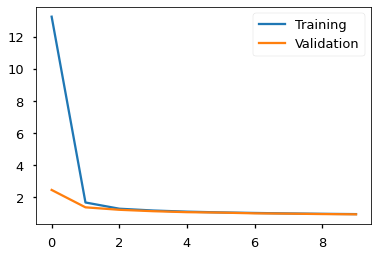

In [ ]:
loss_m = loss.mean(axis=0)
loss_s = loss.var(axis=0)


val_loss_m = val_loss.mean(axis=0)
val_loss_s = val_loss.var(axis=0)

plt.plot(loss_m, label = 'Training')
plt.fill_between(range(len(loss_m)),loss_m-loss_s/2, loss_m+loss_s/2)
plt.plot(val_loss_m, label = 'Validation')
plt.fill_between(range(len(loss_m)),val_loss_m-loss_s/2, val_loss_m+loss_s/2)
plt.legend(loc=0)
plt.show()

In [ ]:
ks_model = KerasClassifier(build_fn=model_fn, epochs=10, batch_size=500, verbose=0)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
results = cross_val_score(ks_model, X, Y, cv=kfold)
print(results.mean())

185/185 [==============================] - 1s 3ms/step - loss: 1.0863 - accuracy: 0.8747
Epoch 5/10
185/185 [==============================] - 1s 3ms/step - loss: 1.0307 - accuracy: 0.8774
Epoch 6/10
185/185 [==============================] - 1s 3ms/step - loss: 0.9866 - accuracy: 0.8791
Epoch 7/10
185/185 [==============================] - 1s 3ms/step - loss: 0.9589 - accuracy: 0.8792
Epoch 8/10
185/185 [==============================] - 1s 3ms/step - loss: 0.9314 - accuracy: 0.8814
Epoch 9/10
185/185 [==============================] - 1s 3ms/step - loss: 0.9105 - accuracy: 0.8828
Epoch 10/10
21/21 [==============================] - 0s 3ms/step - loss: 0.8872 - accuracy: 0.8837
Epoch 1/10
185/185 [==============================] - 1s 3ms/step - loss: 21.7063 - accuracy: 0.6687
Epoch 2/10
185/185 [==============================] - 1s 3ms/step - loss: 1.5076 - accuracy: 0.8679
Epoch 3/10
185/185 [==============================] - 1s 3ms/step - loss: 1.2157 - accuracy: 0.8791
Epoch 4/10


In [ ]:
results

array([0.88100821, 0.89292693, 0.89057159, 0.90327311, 0.89643383,
       0.88754272, 0.90239376, 0.88617492, 0.88373232, 0.88998532])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

csv_logger = CSVLogger('training.log', append=True)
calls=[csv_logger, EarlyStopping(monitor='val_loss', patience=10), ModelCheckpoint('model_log', monitor='acc', save_best_only=True, mode='auto')]


In [ ]:
ks_model = KerasClassifier(build_fn=model_fn, epochs=10, batch_size=500, verbose=0  )
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0 )
results = cross_val_score(ks_model, X, Y, cv=kfold,
                      fit_params = {'callbacks': calls})
print(results.mean())


In [ ]:
import pandas as pd
df = pd.read_csv('training.log')
df.groupby('epoch').mean()

,accuracy,loss
epoch,,
0,0.777454,13.280245
1,0.867018,1.675638
2,0.873090,1.282109
3,0.877511,1.168730
4,0.881014,1.099520
5,0.883573,1.053082
6,0.885181,1.016071
7,0.887867,0.985722
8,0.888141,0.963722


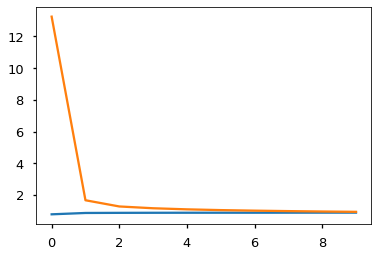

In [ ]:
plt.plot(df.groupby('epoch').mean())

### Tuning

In [ ]:
def model_fn(dense_layer_sizes, regularizations, dropouts, lr=.1):
    model = keras.Sequential()

    model.add(  keras.layers.Flatten(input_shape=(32, 32)) )

    for i in range( len(dense_layer_sizes )):
        model.add( keras.layers.Dense( dense_layer_sizes[i],
                                      activation=tf.nn.relu,
                                      kernel_regularizer=keras.regularizers.l2(regularizations[i])
                                     ) )
        model.add(keras.layers.Dropout( dropouts[i] ) )


    model.add(keras.layers.Dense(10, activation=tf.nn.softmax))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=lr),
                  metrics=['accuracy'])


    return model

mdl = model_fn([100, 30], [.001, .001], [.001, .001], .1)
# mdl = model_fn([128], [.01], [.01])
mdl.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_26 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_100 (Dense)            (None, 100)               102500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 30)                3030      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 10)                310       
Total params: 105,840
Trainable params: 105,840
Non-trainable params: 0
_______________________________________________

In [ ]:
def model_fn(dense_layer_sizes, lr=.1):
    model = keras.Sequential()

    model.add(  keras.layers.Flatten(input_shape=(32, 32)) )

    for i in range( len(dense_layer_sizes )):
        model.add( keras.layers.Dense( dense_layer_sizes[i],
                                      activation=tf.nn.relu #,
                                      # kernel_regularizer=keras.regularizers.l2(regularizations[i])
                                     ) )
        # model.add(keras.layers.Dropout( dropouts[i] ) )


    model.add(keras.layers.Dense(10, activation=tf.nn.softmax))

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=lr),
                  metrics=['accuracy'])


    return model

mdl = model_fn([100, 30], .1)
# mdl = model_fn([128], [.01], [.01])
mdl.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_28 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_106 (Dense)            (None, 100)               102500    
_________________________________________________________________
dense_107 (Dense)            (None, 30)                3030      
_________________________________________________________________
dense_108 (Dense)            (None, 10)                310       
Total params: 105,840
Trainable params: 105,840
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Y_train.shape

(76764, 10)

In [ ]:
btch_size = 500
epch = 3
history = mdl.fit(X_train, Y_train, batch_size=btch_size, epochs=epch )

Epoch 1/3
154/154 [==============================] - 1s 3ms/step - loss: 3.0966 - accuracy: 0.2302
Epoch 2/3
154/154 [==============================] - 1s 3ms/step - loss: 1.4589 - accuracy: 0.3688
Epoch 3/3
154/154 [==============================] - 1s 3ms/step - loss: 1.4039 - accuracy: 0.4468


In [ ]:
# Grid search over these:
dense_size_candidates = [(10, 40), (50) , (20) ]
# regularizations_candidates = [ (.01), (.01), (.001) ]
# dropouts_candidates = [  (.005), (.01), (.003) ]
lr_candidates = [.1]
# epch_list = [4, 10]
batch_size_candidates = 500

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
# from sklearn.model_selection import

gs_classifier = KerasClassifier(model_fn, batch_size=500, epochs=5)


In [ ]:
validator = GridSearchCV(gs_classifier,
                         param_grid={'dense_layer_sizes': dense_size_candidates,
                                     # epochs is avail for tuning even when not
                                     # an argument to model building function
                                     'epochs': [3],
                                    #  'regularizations': regularizations_candidates,
                                    #  'dropouts': dropouts_candidates,
                                     'lr': lr_candidates},
                         scoring='neg_log_loss',
                         n_jobs= 1,  )
validator.fit(X_train, Y_train)

Epoch 1/3
123/123 [==============================] - 1s 3ms/step - loss: 2.1302 - accuracy: 0.2106
Epoch 2/3
123/123 [==============================] - 0s 3ms/step - loss: 1.5675 - accuracy: 0.3712
Epoch 3/3
123/123 [==============================] - 0s 3ms/step - loss: 1.4028 - accuracy: 0.4360
Epoch 1/3
123/123 [==============================] - 1s 3ms/step - loss: 2.4252 - accuracy: 0.1331
Epoch 2/3
123/123 [==============================] - 0s 3ms/step - loss: 2.0549 - accuracy: 0.1869
Epoch 3/3
123/123 [==============================] - 0s 3ms/step - loss: 2.0436 - accuracy: 0.1891
Epoch 1/3
123/123 [==============================] - 1s 3ms/step - loss: 2.1963 - accuracy: 0.2215
Epoch 2/3
123/123 [==============================] - 0s 3ms/step - loss: 1.4566 - accuracy: 0.3992
Epoch 3/3
123/123 [==============================] - 0s 3ms/step - loss: 1.3532 - accuracy: 0.4463
Epoch 1/3
123/123 [==============================] - 1s 3ms/step - loss: 1.7422 - accuracy: 0.3871
Epoch 2/3


GridSearchCV(cv=None, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f23a84c2ed0>,
             iid='deprecated', n_jobs=1,
             param_grid={'dense_layer_sizes': [(10, 40), 50, 20], 'epochs': [3],
                         'lr': [0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

In [ ]:
print('The parameters of the best model are: ')
print(validator.best_params_)

# validator.best_estimator_ returns sklearn-wrapped version of best model.
# validator.best_estimator_.model returns the (unwrapped) keras model
best_model = validator.best_estimator_.model

The parameters of the best model are: 
{'dense_layer_sizes': (10, 40), 'epochs': 3, 'lr': 0.1}


In [ ]:
best_model.save('best_model')

INFO:tensorflow:Assets written to: best_model/assets


### Keras Tuner

https://www.tensorflow.org/tutorials/keras/keras_tuner

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt


     |████████████████████████████████| 98 kB 2.7 MB/s 


In [ ]:
# https://www.tensorflow.org/tutorials/keras/keras_tuner
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(32, 32)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units,
                               activation='relu',
                               kernel_regularizer=keras.regularizers.l2(.05)))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(X_train, Y_train,
             epochs=50,
             batch_size = 100,
             validation_split=0.2,
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 41s]
val_accuracy: 0.9181919097900391

Best val_accuracy So Far: 0.9513450264930725
Total elapsed time: 00h 07m 32s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 448 and the optimal learning rate for the optimizer
is 0.0001.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train,
                    epochs=30,
                    batch_size = 100,
                    validation_data=(X_test, Y_test))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/30
768/768 [==============================] - 4s 4ms/step - loss: 4.4117 - accuracy: 0.8771 - val_loss: 0.4826 - val_accuracy: 0.9174
Epoch 2/30
768/768 [==============================] - 3s 4ms/step - loss: 0.4849 - accuracy: 0.9205 - val_loss: 0.4528 - val_accuracy: 0.9350
Epoch 3/30
768/768 [==============================] - 3s 4ms/step - loss: 0.4407 - accuracy: 0.9328 - val_loss: 0.4437 - val_accuracy: 0.9446
Epoch 4/30
768/768 [==============================] - 3s 4ms/step - loss: 0.4161 - accuracy: 0.9370 - val_loss: 0.3972 - val_accuracy: 0.9417
Epoch 5/30
768/768 [==============================] - 3s 4ms/step - loss: 0.3964 - accuracy: 0.9400 - val_loss: 0.3703 - val_accuracy: 0.9430
Epoch 6/30
768/768 [==============================] - 3s 4ms/step - loss: 0.3762 - accuracy: 0.9443 - val_loss: 0.3698 - val_accuracy: 0.9503
Epoch 7/30
768/768 [==============================] - 3s 4ms/step - loss: 0.3482 - accuracy: 0.9492 - val_loss: 0.3503 - val_accuracy: 0.9497
Epoch 

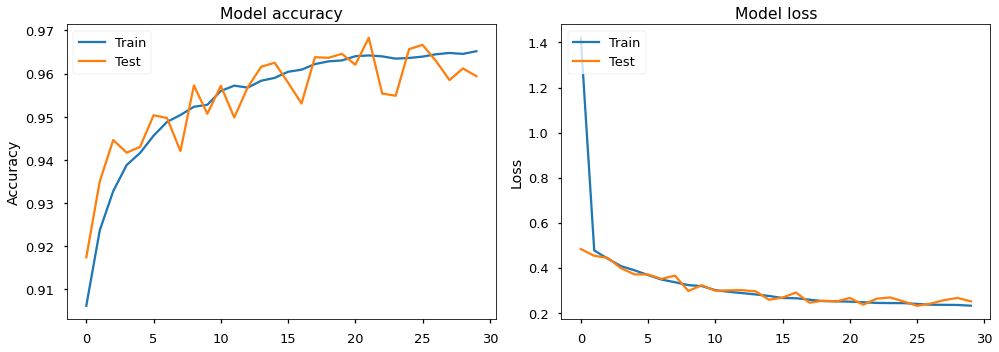

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

## Try this for the particle identification problem.

In [ ]:
import pandas as pd
url = 'https://www.dropbox.com/s/66dbhxl93y41coe/particle-identification-from-detector-responses.zip?dl=1'
s=requests.get(url, stream=True).content
data=pd.read_csv(io.BytesIO(s) , compression='zip' )

'''
Alternatively, you can download the file into your computer and run the following code.
You need to uncomment it first.
'''

# data = pd.read_csv('particle-identification-from-detector-responses.zip', compression='zip')
data.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


In [ ]:
n_s = len(data)
targets = list(set(data['id']))
# mini_data = data.sample(n_s, axis=0, random_state=0)
# data['target'] = data['id'].apply(lambda x: targets.index(x))
data['id'] = pd.Categorical(data.id)
# data.drop('id',axis=1, inplace=True)

data.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


In [ ]:
from sklearn.model_selection import train_test_split
Y_oh = keras.utils.to_categorical(data.id.cat.codes, num_classes=4, dtype=int)
ind_to_keep = ['p', 'beta']
X = data[ind_to_keep].values

X_train, X_test, Y_train, Y_test = train_test_split( data[ind_to_keep], Y_oh, random_state=0)

In [ ]:
Y_train.shape

(3750000, 4)